# EDA
* load data

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
import copy
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly

import pandas as pd
from fbprophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("/content/drive/MyDrive/TimeSeries/train_2.csv",index_col=0)
print(f'{train.shape[0]} time series, each represents the daily views of a webpage')
print(f'From {train.columns.min()} to {train.columns.max()} ({train.shape[1]} days)')
train.head()

145063 time series, each represents the daily views of a webpage
From 2015-07-01 to 2017-09-10 (803 days)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Page,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


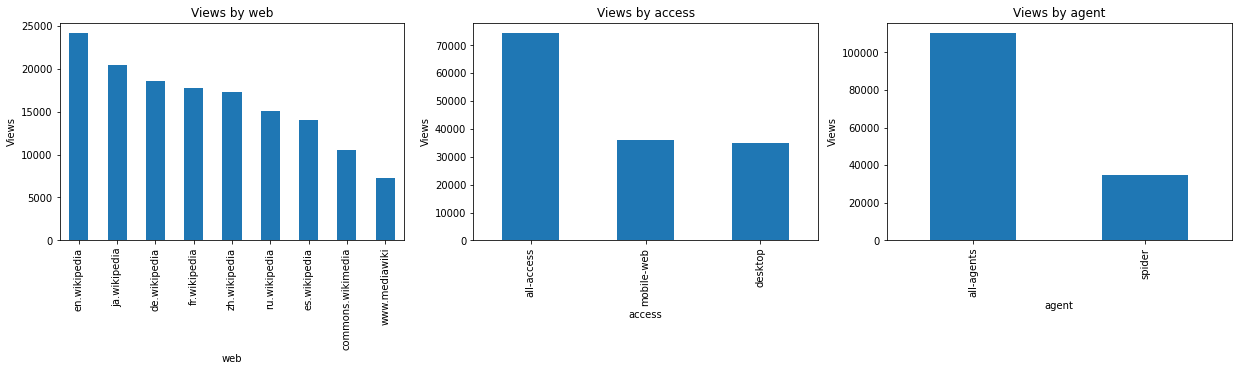

In [ ]:
page_details = train.index.str.extract(r'(?P<topic>.*)\_(?P<web>.*).org\_(?P<access>.*)\_(?P<agent>.*)')
j = 1
plt.figure(figsize=(21,4))
for i in page_details.columns[1:]:
    plt.subplot(1, 3, j)
    page_details[i].value_counts().plot(kind='bar', title='Views by '+i)
    plt.ylabel('Views')
    plt.xlabel(i)
    j+=1

90.7% pages (3208 out of 3537) have no missing value


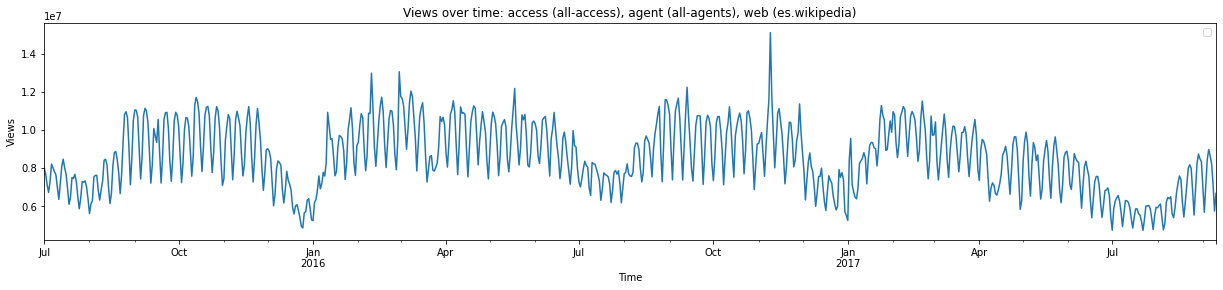

In [ ]:
df = (page_details['access'] == 'all-access') & (page_details['agent'] == 'all-agents') & (page_details['web'] == 'es.wikipedia')
df = train.iloc[df[df].index,:]

complete_num = sum(df.isna().sum(axis=1) == 0)
num = df.shape[0]
print(f'{round(complete_num/num*100, 1)}% pages ({complete_num} out of {num}) have no missing value')

df = df.T.fillna(method='bfill').T.sum().to_frame('y').reset_index().rename(columns={'index': 'ds'})
df['ds'] = pd.to_datetime(df['ds'])
y = df.set_index('ds')
y.plot(figsize=(21,4))
plt.legend('')
plt.title('Views over time: access (all-access), agent (all-agents), web (es.wikipedia)')
plt.ylabel('Views')
plt.xlabel('Time')
plt.show()

In [ ]:
df

,ds,y
0,2015-07-01,8022174.0
1,2015-07-02,7687790.0
2,2015-07-03,7121842.0
3,2015-07-04,6720181.0
4,2015-07-05,7275102.0
...,...,...
798,2017-09-06,8638762.0
799,2017-09-07,8234557.0
800,2017-09-08,7135816.0
801,2017-09-09,5737143.0


In [ ]:
df['ds'] = pd.to_datetime(df['ds']).dt.date

In [ ]:
prediction_size = 60
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
740,2017-07-10,6292498.0
741,2017-07-11,6277017.0
742,2017-07-12,6194045.0


In [ ]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,8.705581e+06,7.924509e+06,9.456254e+06,8.705581e+06,8.705581e+06,-3.705881e+04,-3.705881e+04,-3.705881e+04,9.434921e+05,9.434921e+05,9.434921e+05,-9.805509e+05,-9.805509e+05,-9.805509e+05,0.0,0.0,0.0,8.668522e+06
1,2015-07-02,8.706938e+06,7.280499e+06,8.896235e+06,8.706938e+06,8.706938e+06,-5.647014e+05,-5.647014e+05,-5.647014e+05,4.688531e+05,4.688531e+05,4.688531e+05,-1.033554e+06,-1.033554e+06,-1.033554e+06,0.0,0.0,0.0,8.142236e+06
2,2015-07-03,8.708294e+06,6.182250e+06,7.733858e+06,8.708294e+06,8.708294e+06,-1.788398e+06,-1.788398e+06,-1.788398e+06,-7.045249e+05,-7.045249e+05,-7.045249e+05,-1.083873e+06,-1.083873e+06,-1.083873e+06,0.0,0.0,0.0,6.919897e+06
3,2015-07-04,8.709651e+06,5.204229e+06,6.693073e+06,8.709651e+06,8.709651e+06,-2.792258e+06,-2.792258e+06,-2.792258e+06,-1.660687e+06,-1.660687e+06,-1.660687e+06,-1.131571e+06,-1.131571e+06,-1.131571e+06,0.0,0.0,0.0,5.917392e+06
4,2015-07-05,8.711007e+06,6.093760e+06,7.624058e+06,8.711007e+06,8.711007e+06,-1.848156e+06,-1.848156e+06,-1.848156e+06,-6.713856e+05,-6.713856e+05,-6.713856e+05,-1.176771e+06,-1.176771e+06,-1.176771e+06,0.0,0.0,0.0,6.862851e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,2017-09-06,6.264816e+06,7.307545e+06,8.892670e+06,6.229400e+06,6.301467e+06,1.846839e+06,1.846839e+06,1.846839e+06,9.434921e+05,9.434921e+05,9.434921e+05,9.033465e+05,9.033465e+05,9.033465e+05,0.0,0.0,0.0,8.111655e+06
799,2017-09-07,6.253092e+06,6.807340e+06,8.358181e+06,6.216782e+06,6.290739e+06,1.346318e+06,1.346318e+06,1.346318e+06,4.688531e+05,4.688531e+05,4.688531e+05,8.774647e+05,8.774647e+05,8.774647e+05,0.0,0.0,0.0,7.599409e+06
800,2017-09-08,6.241367e+06,5.638393e+06,7.169313e+06,6.203976e+06,6.280213e+06,1.414715e+05,1.414715e+05,1.414715e+05,-7.045249e+05,-7.045249e+05,-7.045249e+05,8.459964e+05,8.459964e+05,8.459964e+05,0.0,0.0,0.0,6.382839e+06
801,2017-09-09,6.229643e+06,4.646066e+06,6.207696e+06,6.191122e+06,6.269739e+06,-8.506676e+05,-8.506676e+05,-8.506676e+05,-1.660687e+06,-1.660687e+06,-1.660687e+06,8.100193e+05,8.100193e+05,8.100193e+05,0.0,0.0,0.0,5.378975e+06


In [ ]:
residual = forecast.tail(n=60)["yhat"] - df.tail(n=60)["y"]
residual

743   -3.971977e+04
744   -6.819531e+05
745   -1.174425e+06
746   -7.831191e+05
747    4.623890e+04
748    3.101876e+05
749    4.968091e+05
750    5.883551e+04
751   -8.275524e+05
752   -1.353645e+06
753   -9.495127e+05
754   -3.830162e+05
755   -1.118625e+05
756   -1.899132e+05
757   -5.240496e+05
758   -1.199351e+06
759   -1.580392e+06
760   -1.323684e+06
761   -4.423211e+05
762   -9.363288e+04
763   -2.241735e+05
764   -7.528667e+05
765   -1.157109e+06
766   -1.450498e+06
767   -7.287044e+05
768   -4.681912e+05
769   -3.326861e+05
770   -2.181001e+05
771   -7.111769e+05
772   -8.820642e+05
773   -1.545184e+06
774   -9.922494e+05
775   -3.376317e+05
776   -3.945353e+05
777   -6.811385e+05
778   -8.596555e+05
779   -7.155203e+05
780   -7.729657e+05
781   -4.487840e+05
782    7.356113e+04
783   -3.704756e+05
784   -4.841709e+05
785   -6.851184e+05
786   -5.938429e+05
787   -1.903055e+05
788   -4.864459e+05
789   -4.592678e+05
790   -6.032403e+05
791   -3.458491e+05
792   -6.451366e+05


In [ ]:
prediction = forecast.tail(n=60)["yhat"]
actual = df.tail(n=60)["y"]

In [ ]:
#MAE
np.mean(np.abs(prediction - actual))

602345.3072766126

In [ ]:
#MAPE
np.mean(np.abs(prediction - actual)/np.abs(actual))

0.10066207318681068

In [ ]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
#sMAPE
smape = smape(df.tail(n=60)["y"], forecast.tail(n=60)["yhat"])
smape

10.95887882352413

The SMAPE score is : 10.95888


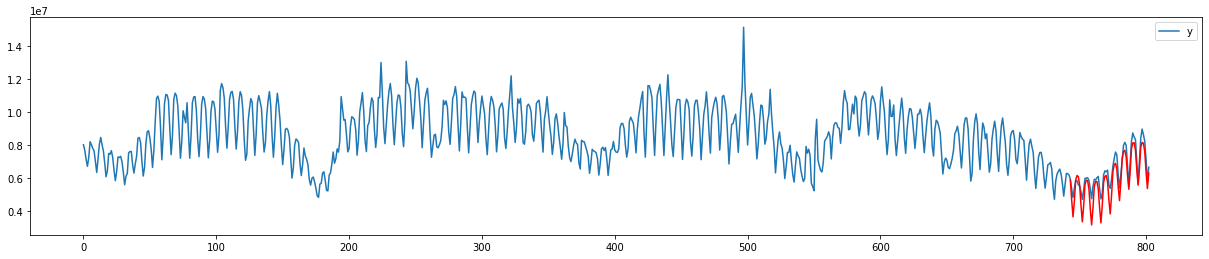

In [ ]:
df.plot(figsize=(21,4))
prediction.plot(color='red')
print("The SMAPE score is : %.5f" % smape)

In [ ]:
modeltuned2 = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10)
modeltuned2.fit(train_df)
future_data2 = modeltuned2.make_future_dataframe(periods=prediction_size)
forecast_data2 = modeltuned2.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prediction_2 = forecast_data2.tail(n=60)["yhat"]
actual = df.tail(n=60)["y"]

In [ ]:
#MAE
np.mean(np.abs(prediction_2 - actual))

355137.9239842149

In [ ]:
#MAPE
np.mean(np.abs(prediction_2 - actual)/np.abs(actual))

0.0635541414706105

In [ ]:
#sMAPE
smape2 = smape(df.tail(n=60)["y"], forecast_data2.tail(n=60)["yhat"])
smape2

6.755329481263392

The SMAPE score is : 6.75533
changepoint_prior_scale=0.5, seasonality_prior_scale=10


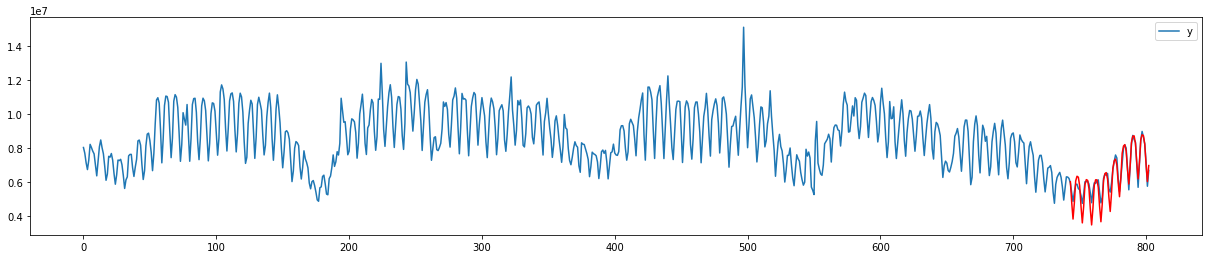

In [ ]:
df.plot(figsize=(21,4))
prediction_2.plot(color='red')
print("The SMAPE score is : %.5f" % smape2)
print("changepoint_prior_scale=0.5, seasonality_prior_scale=10")